In [4]:
import torch.nn.functional as F
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
with open('chat.txt', "r+") as file:
    chat = file.readlines()

In [6]:
chat = "\n".join(chat)

In [7]:
chars = sorted(list(set(chat))) + ['<s>']
vocab_size = len(chars)
tokeniser = {c:i  for i, c in enumerate(chars)}
detokeniser = {i:c  for i, c in enumerate(chars)}

In [8]:
sentence_enc = [tokeniser[c] for c in chat[:100]]
sentence_dec = [detokeniser[t] for t in sentence_enc]
sentence_enc, "".join(sentence_dec)

([61,
  19,
  23,
  17,
  18,
  26,
  17,
  20,
  18,
  20,
  23,
  14,
  2,
  19,
  18,
  28,
  22,
  23,
  28,
  22,
  21,
  63,
  2,
  45,
  74,
  79,
  72,
  84,
  2,
  37,
  83,
  80,
  84,
  84,
  2,
  42,
  66,
  68,
  76,
  2,
  46,
  66,
  67,
  28,
  2,
  133,
  47,
  70,
  84,
  84,
  66,
  72,
  70,
  84,
  2,
  66,
  79,
  69,
  2,
  68,
  66,
  77,
  77,
  84,
  2,
  66,
  83,
  70,
  2,
  70,
  79,
  69,
  15,
  85,
  80,
  15,
  70,
  79,
  69,
  2,
  70,
  79,
  68,
  83,
  90,
  81,
  85,
  70,
  69,
  16,
  2,
  49,
  79,
  77,
  90,
  2,
  81,
  70,
  80,
  81],
 '[15/08/2025, 10:45:43] Kings Cross Hack Lab: \u200eMessages and calls are end-to-end encrypted. Only peop')

In [26]:

# generating the dataset
CONTEXT_LENGTH = 4
X = []
Y = []

context = ['<s>'] * CONTEXT_LENGTH
for i, c in enumerate(chat):
    context = context[1:] + [c]
    X.append([tokeniser[c] for c in context]) 
    if i == len(chat) - 1:
        Y.append([tokeniser[c] for c in context[1:] + [' ']])
    else:
        Y.append([tokeniser[c] for c in context[1:] + [chat[i+1]]])

X = torch.tensor(X)
Y = torch.tensor(Y)

tst_idx = int(X.shape[0])
val_idx = int(tst_idx * 0.9)
tr_idx =  int(tst_idx * 0.8)

X_tr = X[0:tr_idx]
Y_tr = Y[0:tr_idx]

X_val = X[tr_idx:tst_idx]
Y_val = Y[tr_idx:tst_idx]

X_tst = X[val_idx:]
Y_tst = Y[val_idx:]

In [28]:
emb = torch.randn(vocab_size, 2)
emb.shape

torch.Size([343, 2])

In [29]:
small_X = X[:200]

print(small_X.shape)

emb_X = emb[small_X]

torch.Size([200, 4])


In [117]:
attn = torch.zeros_like(emb_X).float()

for i, x in enumerate(emb_X):
    for j, c in enumerate(x):
        attn[i,j] = (x[:j+1].float()).mean(0)

In [118]:
emb_X[5]

tensor([[ 1.0012, -1.3091],
        [ 0.4356, -0.3819],
        [-1.4243, -0.0738],
        [ 0.5725,  2.0946]])

In [119]:
attn[5]

tensor([[ 1.0012, -1.3091],
        [ 0.7184, -0.8455],
        [ 0.0042, -0.5883],
        [ 0.1463,  0.0825]])

In [124]:
attn_v = (emb_X.transpose(1,2) @ torch.triu(1/torch.arange(1,5,1).expand(4,4), diagonal=0)).transpose(-2,-1)
attn_v[5]

tensor([[ 1.0012, -1.3091],
        [ 0.7184, -0.8455],
        [ 0.0042, -0.5883],
        [ 0.1463,  0.0825]])

In [138]:
torch.triu(1/torch.arange(1,5,1).expand(4,4), diagonal=0)

tensor([[1.0000, 0.5000, 0.3333, 0.2500],
        [0.0000, 0.5000, 0.3333, 0.2500],
        [0.0000, 0.0000, 0.3333, 0.2500],
        [0.0000, 0.0000, 0.0000, 0.2500]])

In [ ]:
emb_X[5] # (T, C) -> (4, 2)

tensor([[ 1.0012, -1.3091],
        [ 0.4356, -0.3819],
        [-1.4243, -0.0738],
        [ 0.5725,  2.0946]])

In [175]:
emb_X.exp() / emb_X.exp().sum(0)

tensor([[[0.0039, 0.0022],
         [0.0039, 0.0022],
         [0.0039, 0.0022],
         [0.0101, 0.0017]],

        [[0.0039, 0.0022],
         [0.0039, 0.0022],
         [0.0100, 0.0017],
         [0.0008, 0.0123]],

        [[0.0039, 0.0022],
         [0.0101, 0.0018],
         [0.0008, 0.0124],
         [0.0077, 0.0008]],

        ...,

        [[0.0066, 0.0012],
         [0.0018, 0.0021],
         [0.0028, 0.0020],
         [0.0043, 0.0077]],

        [[0.0018, 0.0021],
         [0.0028, 0.0021],
         [0.0043, 0.0078],
         [0.0062, 0.0341]],

        [[0.0028, 0.0021],
         [0.0043, 0.0081],
         [0.0062, 0.0344],
         [0.0017, 0.0099]]])

In [174]:
torch.tril(1/torch.arange(4,0,-1).expand(4,4), diagonal=0)

tensor([[0.2500, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.3333, 0.0000, 0.0000],
        [0.2500, 0.3333, 0.5000, 0.0000],
        [0.2500, 0.3333, 0.5000, 1.0000]])

In [163]:
emb_X[5].T @ (emb_X[5] / emb_X[5].sum(0)).float()

tensor([[ 6.0645, -0.5241],
        [-0.2955, 18.9556]])

In [139]:
attn_v_t = torch.tril(1/torch.arange(4,0,-1).expand(4,4), diagonal=0) @ emb_X
attn_v_t[5]

tensor([[ 0.2503, -0.3273],
        [ 0.3955, -0.4546],
        [-0.3166, -0.4915],
        [ 0.2559,  1.6032]])

In [68]:
X.shape, torch.triu(1/torch.arange(1,9,1).expand(8,8), diagonal=0).shape

(torch.Size([618527, 8]), torch.Size([8, 8]))

In [81]:
(torch.randn(123, 8, 5).transpose(1,2) @ torch.triu(1/torch.arange(1,9,1).expand(8,8), diagonal=0)).shape

torch.Size([123, 5, 8])

In [76]:
torch.randn(4,2,3).transpose(-1,-2).shape

torch.Size([4, 3, 2])

In [94]:
attn_v = X.float() @ torch.triu(1/torch.arange(1,9,1).expand(8,8), diagonal=0)

In [97]:
(attn == attn_v)

tensor([[ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True, False,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True]])

In [104]:
sm = torch.triu(torch.ones(8,8), diagonal=0)
sm = torch.masked_fill(sm, sm == 0, float('-inf'))
sm

tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [-inf, 1., 1., 1., 1., 1., 1., 1.],
        [-inf, -inf, 1., 1., 1., 1., 1., 1.],
        [-inf, -inf, -inf, 1., 1., 1., 1., 1.],
        [-inf, -inf, -inf, -inf, 1., 1., 1., 1.],
        [-inf, -inf, -inf, -inf, -inf, 1., 1., 1.],
        [-inf, -inf, -inf, -inf, -inf, -inf, 1., 1.],
        [-inf, -inf, -inf, -inf, -inf, -inf, -inf, 1.]])

In [122]:
sm_exp = torch.exp(sm)
sm_ans = sm_exp / sm_exp.sum(dim=0)
sm_ans

tensor([[1.0000, 0.5000, 0.3333, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.5000, 0.3333, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.3333, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250]])

In [123]:
sm_exp

tensor([[2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183],
        [0.0000, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183],
        [0.0000, 0.0000, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183],
        [0.0000, 0.0000, 0.0000, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.7183, 2.7183, 2.7183, 2.7183],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.7183, 2.7183, 2.7183],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.7183, 2.7183],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.7183]])

In [124]:
sm_exp = torch.triu(torch.ones(8,8), diagonal=0)
sm_ans = sm_exp / sm_exp.sum(dim=0)
sm_ans

tensor([[1.0000, 0.5000, 0.3333, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.5000, 0.3333, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.3333, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250]])

In [110]:
F.softmax(sm, dim=1)

tensor([[0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.0000, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429],
        [0.0000, 0.0000, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.0000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.2500, 0.2500, 0.2500],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.3333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]])

In [9]:

# generating the dataset
CONTEXT_LENGTH = 128
X = []
Y = []

context = ['<s>'] * CONTEXT_LENGTH
for i, c in enumerate(chat):
    context = context[1:] + [c]
    X.append([tokeniser[c] for c in context]) 
    if i == len(chat) - 1:
        Y.append([tokeniser[c] for c in context[1:] + [' ']])
    else:
        Y.append([tokeniser[c] for c in context[1:] + [chat[i+1]]])

X = torch.tensor(X)
Y = torch.tensor(Y)

tst_idx = int(X.shape[0])
val_idx = int(tst_idx * 0.9)
tr_idx =  int(tst_idx * 0.8)

X_tr = X[0:tr_idx]
Y_tr = Y[0:tr_idx]

X_val = X[tr_idx:tst_idx]
Y_val = Y[tr_idx:tst_idx]

X_tst = X[val_idx:]
Y_tst = Y[val_idx:]

In [10]:
Y_tr.shape, X_tr.shape

(torch.Size([494821, 128]), torch.Size([494821, 128]))

In [35]:
TOK_EMB_DIM = 64
POS_EMB_DIM = 64

HEAD_SIZE = 16
NUM_HEADS = 16

DROPOUT_RATE = 0.2

COMPRESSION_RATIO = 4
HIDDEN_DIM = TOK_EMB_DIM // COMPRESSION_RATIO
Z_DIM = HIDDEN_DIM // COMPRESSION_RATIO

MINI_NUM_HEADS = 2


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = "cpu"

class BasicTransformer(nn.Module):
    def __init__(self):
        super().__init__()

        self.tok_emb = nn.Embedding(vocab_size, TOK_EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, POS_EMB_DIM)
        self.flatten = nn.Flatten()

        self.query = nn.Linear(TOK_EMB_DIM, HEAD_SIZE) # (C, H)
        self.key = nn.Linear(TOK_EMB_DIM, HEAD_SIZE) # (C, H)
        self.value = nn.Linear(TOK_EMB_DIM, HEAD_SIZE) # (C, H)
        self.linear1 = nn.Linear(CONTEXT_LENGTH * HEAD_SIZE, vocab_size)


    def forward(self, x, y = None):
        # (B, T)
        tok_emb = self.tok_emb(x) # (B, T, C)
        pos_emb = self.pos_emb(torch.arange(0,CONTEXT_LENGTH)) # (B, T, C)
        x = tok_emb + pos_emb # (B, T, C)

        query = self.query(x) # B, (T, C) @ (C, H) -> B, (T, H)
        key = self.key(x) # B, (T, C) @ (C, H) -> B, (T, H)
        value: torch.Tensor = self.value(x) # B, (T, C) @ (C, H) -> B, (T, H)

        contrib = query @ key.transpose(1,2) # B, (T, H) @ (H, T) -> (T, T)
        contrib = torch.triu(contrib, diagonal=0) # (T, T)
        contrib = torch.masked_fill(contrib, contrib == 0, float('-inf')) # (T, T)
        contrib = torch.softmax(contrib * (HEAD_SIZE ** -0.5), dim=-1) # (T, T)
        x = (value.transpose(-2, -1) @ contrib).transpose(-2,-1) # B, (H, T) @ (T, T) -> H, T -> B, T, H

        x = self.flatten(x)
        logits = self.linear1(x)

        loss = None

        if y is not None:
            loss = F.cross_entropy(logits, y)

        return logits, loss
    
    def generate(self, x):
        logits, _ = self.forward(x)
        probs = F.softmax(logits, dim=1)
        pred = torch.multinomial(probs, 1)

        return pred
    
class TransformerWithAttn(nn.Module):
    def __init__(self):
        super().__init__()

        self.tok_emb = nn.Embedding(vocab_size, TOK_EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, POS_EMB_DIM)
        self.flatten = nn.Flatten()

        self.attn1 = Attention(TOK_EMB_DIM, HEAD_SIZE)
        self.linear1 = nn.Linear(CONTEXT_LENGTH * HEAD_SIZE, vocab_size)


    def forward(self, x, y = None):
        # (B, T)
        tok_emb = self.tok_emb(x) # (B, T, C)
        pos_emb = self.pos_emb(torch.arange(0,CONTEXT_LENGTH)) # (B, T, C)
        x = tok_emb + pos_emb # (B, T, C)

        x = self.attn1(x)
        x = self.flatten(x)
        logits = self.linear1(x)

        loss = None

        if y is not None:
            loss = F.cross_entropy(logits, y)

        return logits, loss
    
    def generate(self, x):
        logits, _ = self.forward(x)
        probs = F.softmax(logits, dim=1)
        pred = torch.multinomial(probs, 1)

        return pred


class TransformerWithMultiHeadAttn(nn.Module):
    def __init__(self):
        super().__init__()

        self.tok_emb = nn.Embedding(vocab_size, TOK_EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, POS_EMB_DIM)
        self.flatten = nn.Flatten()

        self.attn1 = MultiHeadAttention(num_heads=TOK_EMB_DIM // HEAD_SIZE, embedding_dim=TOK_EMB_DIM, head_size=HEAD_SIZE)
        self.linear1 = nn.Linear(CONTEXT_LENGTH * TOK_EMB_DIM, vocab_size)


    def forward(self, x, y = None):
        # (B, T)
        tok_emb = self.tok_emb(x) # (B, T, C)
        pos_emb = self.pos_emb(torch.arange(0,CONTEXT_LENGTH)) # (B, T, C)
        x = tok_emb + pos_emb # (B, T, C)

        x = self.attn1(x) # (B, T, H), 
        # num_heads = TOK_EMB_DIM // HEAD_SIZE
        # H * num_heads = tok_emb
        # therefore, x (B, T, tok_emb)

        x = self.flatten(x)
        logits = self.linear1(x)

        loss = None

        if y is not None:
            loss = F.cross_entropy(logits, y)

        return logits, loss
    
    def generate(self, x):
        logits, _ = self.forward(x)
        probs = F.softmax(logits, dim=1)
        pred = torch.multinomial(probs, 1)

        return pred

class Storage(nn.Module):
    def __init__(self):
        super().__init__()

        self.z_store = []

    def forward(self, z):
        if self.training == False:
            self.z_store.append(z.detach())

class VAETransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, TOK_EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, POS_EMB_DIM)
        self.attn = MultiHeadAttention(num_heads=NUM_HEADS, embedding_dim=TOK_EMB_DIM, head_size=TOK_EMB_DIM // NUM_HEADS)
        
        self.vae = VariationalAutoAttentionEncoder(input_dim=TOK_EMB_DIM, hidden_dim=HIDDEN_DIM, z_dim=Z_DIM)
        self.attn_z = MultiHeadAttention(num_heads=MINI_NUM_HEADS, embedding_dim=Z_DIM, head_size=Z_DIM // MINI_NUM_HEADS)

        self.layer_norm = nn.LayerNorm(TOK_EMB_DIM)
        self.linear = nn.Linear(TOK_EMB_DIM, vocab_size)
        self.flatten = nn.Flatten()
        
        # Storage for z latents during generation
        self.z_latents_store = []
        self.vae_training = True

    def forward(self, x, y = None):
        # (B, T)
        if self.vae_training:
            self.vae.vae_training = True

        tok_emb = self.tok_emb(x) # (B, T, C)
        pos_emb = self.pos_emb(torch.arange(0,CONTEXT_LENGTH).to(device)) # (B, T, C)
        x = tok_emb + pos_emb # (B, T, C)


        x_hoc, vae_loss = self.vae(x)
        x_res = x
        x = self.attn(x)

        if self.vae_training:
            x = x + x_res
        else:
            x = x + x_hoc + x_res

        x = self.layer_norm(x)
        logits = self.linear(x)

        loss = None

        if y is not None:
            loss = F.cross_entropy(logits.view(logits.shape[0] * logits.shape[1], vocab_size), y.view(y.shape[0] * y.shape[1])) + vae_loss

        return logits, loss
    
    def generate(self, x):
        logits, _ = self.forward(x)
        logits = logits[:,-1,:]
        probs = F.softmax(logits, dim=-1)
        pred = torch.multinomial(probs, 1)

        return pred
    
    def clear_latents(self):
        """Clear the stored latents"""
        self.z_latents_store = []
    
    def get_latents(self):
        """Get all stored latents as a tensor"""
        if len(self.z_latents_store) == 0:
            return None
        return torch.cat(self.z_latents_store, dim=0)


class ControlVAETransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, TOK_EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, POS_EMB_DIM)
        self.attn = MultiHeadAttention(num_heads=NUM_HEADS, embedding_dim=TOK_EMB_DIM, head_size=TOK_EMB_DIM // NUM_HEADS)
        self.layer_norm = nn.LayerNorm(TOK_EMB_DIM)
        self.linear = nn.Linear(TOK_EMB_DIM, vocab_size)
        

    def forward(self, x, y = None):
        # (B, T)
        tok_emb = self.tok_emb(x) # (B, T, C)
        pos_emb = self.pos_emb(torch.arange(0,CONTEXT_LENGTH).to(device)) # (B, T, C)
        x = tok_emb + pos_emb # (B, T, C)

        x_res = x
        x = self.attn(x)
        x = x + x_res
        x = self.layer_norm(x)
        logits = self.linear(x)

        loss = None

        if y is not None:
            loss = F.cross_entropy(logits.view(logits.shape[0] * logits.shape[1], vocab_size), y.view(y.shape[0] * y.shape[1]))

        return logits, loss
    
    def generate(self, x):
        logits, _ = self.forward(x)
        logits = logits[:,-1,:]
        probs = F.softmax(logits, dim=-1)
        pred = torch.multinomial(probs, 1)

        return pred
    
    def clear_latents(self):
        """Clear the stored latents"""
        self.z_latents_store = []
    
    def get_latents(self):
        """Get all stored latents as a tensor"""
        if len(self.z_latents_store) == 0:
            return None
        return torch.cat(self.z_latents_store, dim=0)



class Transformer(nn.Module):
    def __init__(self, num_blocks):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, TOK_EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, POS_EMB_DIM)
        self.blocks = nn.Sequential(*[TransformerBlock(TOK_EMB_DIM, NUM_HEADS) for _ in range(num_blocks)])
        self.layer_norm = nn.LayerNorm(TOK_EMB_DIM)
        self.linear = nn.Linear(TOK_EMB_DIM, vocab_size)
        self.flatten = nn.Flatten()

    def forward(self, x, y = None):
        # (B, T)
        tok_emb = self.tok_emb(x) # (B, T, C)
        pos_emb = self.pos_emb(torch.arange(0,CONTEXT_LENGTH).to(device)) # (B, T, C)
        x = tok_emb + pos_emb # (B, T, C)

        x = self.blocks(x)

        x = self.layer_norm(x)
        logits = self.linear(x) # (B, T, vocab_size)

        loss = None

        if y is not None:
            loss = F.cross_entropy(logits.view(logits.shape[0] * logits.shape[1], vocab_size), y.view(y.shape[0] * y.shape[1]))

        return logits, loss
    
    def generate(self, x):
        logits, _ = self.forward(x)
        logits = logits[:,-1,:]
        probs = F.softmax(logits, dim=-1)
        pred = torch.multinomial(probs, 1)

        return pred

class TransformerBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super().__init__()

        self.attn1 = MultiHeadAttention(num_heads=num_heads, embedding_dim=embedding_dim, head_size=embedding_dim // num_heads)
        # self.attn2 = MultiHeadAttention(num_heads=embedding_dim // head_size, embedding_dim=embedding_dim, head_size=head_size)
        self.mlp = MLP(embedding_dim=embedding_dim, expansion_factor=4)
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)


    def forward(self, x):
        out = self.layer_norm1(x)
        x = x + self.attn1(out) # (B, T, C)
        # x = self.attn2(x) # (B, T, C)
        out = self.layer_norm2(x)
        x = x + self.mlp(out) # (B, T, C)

        return x
    
class MLPLayer(nn.Module):
    def __init__(self, input_dim, output_dim, use_relu=True):
        super().__init__()

        self.linear = nn.Linear(input_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(DROPOUT_RATE)

        self.use_relu = use_relu

    def forward(self, x):
        # (B, T, I)
        x = self.linear(x) # (B, T, O)

        if self.use_relu:
            x = self.relu(x)

        x = self.dropout(x)

        return x


class MLP(nn.Module):
    def __init__(self, embedding_dim, expansion_factor):
        super().__init__()

        self.linear1 = nn.Linear(embedding_dim, expansion_factor * embedding_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(embedding_dim * expansion_factor, embedding_dim)
        self.dropout = nn.Dropout(DROPOUT_RATE)

    def forward(self, x):
        # (B, T, tok_emb)
        x = self.linear1(x) # (B, T, 4 * tok_emb)
        x = self.relu(x) # (B, T, 4 * tok_emb)
        x = self.linear2(x) # (B, T, tok_emb)
        x = self.dropout(x)

        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, embedding_dim, head_size):
        super().__init__()

        self.attns = nn.ModuleList(Attention(embedding_dim, head_size) for _ in range(num_heads))
        self.projection = nn.Linear(embedding_dim, embedding_dim)


    def forward(self, x):
        x = torch.concat([attn(x) for attn in self.attns], dim=-1) 
        # B, T, (H x num_heads) -> (4 x 8) -> 32 == C (tok_emd)
        x = self.projection(x)

        return x
    

class Attention(nn.Module):
    def __init__(self, embedding_dim, head_size):
        super().__init__()
        self.query = nn.Linear(embedding_dim, head_size) # (C, H)
        self.key = nn.Linear(embedding_dim, head_size) # (C, H)
        self.value = nn.Linear(embedding_dim, head_size) # (C, H)

        self.head_size = head_size

    def forward(self, x):
        query = self.query(x) # B, (T, C) @ (C, H) -> B, (T, H)
        key = self.key(x) # B, (T, C) @ (C, H) -> B, (T, H)
        value: torch.Tensor = self.value(x) # B, (T, C) @ (C, H) -> B, (T, H)
        B, T, C = x.shape

        contrib = query @ key.transpose(-2,-1) # B, (T, H) @ (H, T) -> (T, T)
        contrib = contrib * (self.head_size ** -0.5)
        tril = torch.tril(torch.ones(T, T, device=x.device)) 
        contrib = contrib.masked_fill(tril == 0, float('-inf')) # (T, T)
        contrib = F.softmax(contrib, dim=-1) # (T, T)


        # contrib = query @ key.transpose(-2,-1) # B, (T, H) @ (H, T) -> (T, T)
        # contrib = torch.triu(contrib, diagonal=0).to(device) # (T, T)
        # contrib = torch.masked_fill(contrib, contrib == 0, float('-inf')) # (T, T)
        # contrib = torch.softmax(contrib * (self.head_size ** -0.5), dim=-1) # (T, T)
        # x = (value.transpose(-2, -1) @ contrib).transpose(-2,-1) # B, (H, T) @ (T, T) -> H, T -> B, T, H
        
        x = contrib @ value #(T, T) @  B, (T, H) -> H, T -> B, T, H
        
        return x
    
class AttentionEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super().__init__()
        self.attn = Attention(input_dim, hidden_dim)
        self.mlp_mu = MLPLayer(hidden_dim, z_dim, use_relu=False)
        self.mlp_sigma = MLPLayer(hidden_dim, z_dim, use_relu=False)

    def forward(self, x):
        x = self.attn(x)
        mu = self.mlp_mu(x)
        sigma = self.mlp_sigma(x)

        return mu, sigma


class CrossAttention(nn.Module):
    def __init__(self, embedding_dim, head_size):
        super().__init__()
        self.query = nn.Linear(embedding_dim, head_size) # (C, H)
        self.key = nn.Linear(embedding_dim, head_size) # (C, H)
        self.value = nn.Linear(embedding_dim, head_size) # (C, H)

        self.head_size = head_size

    def forward(self, x_db, x_client):
        query = self.query(x_client) # B, (T, C) @ (C, H) -> B, (T, H)
        key = self.key(x_db) # B, (T, C) @ (C, H) -> B, (T, H)
        value = self.value(x_db) # B, (T, C) @ (C, H) -> B, (T, H)

        B, T, C = x.shape

        contrib = query @ key.transpose(-2,-1) # B, (T, H) @ (H, T) -> (T, T)
        contrib = contrib * (self.head_size ** -0.5)
        tril = torch.tril(torch.ones(T, T, device=x.device))
        contrib = contrib.masked_fill(tril == 0, float('-inf'))
        contrib = F.softmax(contrib, dim=-1)

        x = contrib @ value
        
        return x


class VariationalAutoAttentionEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super().__init__()

        self.relu = nn.ReLU()

        self.attn_enc = AttentionEncoder(input_dim, hidden_dim, z_dim)

        # VAE decoder
        self.z_2_hid = nn.Linear(z_dim, hidden_dim)
        self.hid_2_img = nn.Linear(hidden_dim, input_dim)

        # Transformer decoder
        self.z_2_hid_transformer = MLPLayer(z_dim, hidden_dim)
        self.hid_2_img_transformer = MLPLayer(hidden_dim, input_dim, use_relu=False)

        self.vae_training = True

    def encoder(self, x):
        mu, sigma = self.attn_enc(x)

        return mu, sigma
    
    def decoder(self, z):
        if self.vae_training:
            z = self.z_2_hid(z)
            x = self.hid_2_img(z)
        else:
            z = self.z_2_hid_transformer(z)
            x = self.hid_2_img_transformer(z) 

        return x
    
    def sample_z(self, mu, sigma):
        z = mu + (sigma * torch.randn_like(sigma))

        return z
    
    def forward(self, x, calc_loss=True):
        mu, sigma = self.encoder(x)
        z = mu + (sigma * torch.randn_like(sigma))
        recons = self.decoder(z)

        loss = None

        if calc_loss:
            kl_loss = 0.5 * (mu ** 2 + sigma ** 2 - torch.log(sigma **2) -1).mean()
            bce_loss = - (x * torch.log(recons) + (1-x) * torch.log(1 - recons)).sum()

            loss = kl_loss + bce_loss
        
        return recons, loss


class HippoNeoCorticalTransformer(nn.Module):
    def __init__(self):
        super().__init__()

        self.long_term_storage = AutoEncoder(TOK_EMB_DIM, CONTEXT_LENGTH)
        self.block = TransformerBlock(TOK_EMB_DIM, HEAD_SIZE)

        self.x_attn1 = CrossAttention(TOK_EMB_DIM, HEAD_SIZE)
        self.x_attn2 = CrossAttention(TOK_EMB_DIM, HEAD_SIZE)

        self.mlp = MLP(TOK_EMB_DIM, 4)

    def identity_upsample(self, x):
        # TO BE IMPLEMENTED, to upsample latents to fit the dimensions for cross attention
        return x

    def forward(self, x):
        recons, latents = self.long_term_storage(x)

        x = self.block(x) # (B, T, C)

        # identity upsample

        x = self.x_attn1(self.identity_upsample(latents), x)
        x = self.x_attn2(recons, x)

        x = self.mlp(x)

        return x


In [79]:
def count_params(model):
    count = 0
    for param in model.parameters():
        count += param.numel()

    return count


def generate_tokens(model, num_tokens, initial_text = ""):
    generated = initial_text
    init_length = len(initial_text)
    context = ([tokeniser['<s>']] * (CONTEXT_LENGTH - init_length)) + [tokeniser[i] for i in initial_text]
    # context = [tokeniser[c] for c in "[07/12/2025, 11:06:52] Yi Hein: how will we ever know when FEP assumptions hold true? if not we will just be applying it wrongly"]
    for i in range(num_tokens):
        pred = model.generate(torch.tensor(context).unsqueeze(0).to(device))
        token = pred.item()

        context = context[1:] + [token]
        generated += detokeniser[token]
    return generated


In [32]:
model = Transformer(num_blocks=4).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
losses = []

In [33]:
# for ep in range(1000):
model.train()
for ep in range(50_000):
    batch_ix = torch.randint(0, X_tr.shape[0], (64,))
    xs = X_tr[batch_ix].to(device)
    y = Y_tr[batch_ix].to(device)

    logits, loss = model.forward(xs, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # log every 1000 epochs
    if ep % 1000 == 0:
        print(f"Epoch {ep}, Loss: {loss.item()}")

Epoch 0, Loss: 5.976536750793457
Epoch 1000, Loss: 1.8736846446990967
Epoch 2000, Loss: 1.680092215538025
Epoch 3000, Loss: 1.4936562776565552
Epoch 4000, Loss: 1.3828716278076172
Epoch 5000, Loss: 1.3913607597351074
Epoch 6000, Loss: 1.348974585533142
Epoch 7000, Loss: 1.3748488426208496
Epoch 8000, Loss: 1.2782964706420898
Epoch 9000, Loss: 1.3007844686508179
Epoch 10000, Loss: 1.2167797088623047
Epoch 11000, Loss: 1.1886427402496338
Epoch 12000, Loss: 1.2306809425354004
Epoch 13000, Loss: 1.2719131708145142
Epoch 14000, Loss: 1.254906415939331
Epoch 15000, Loss: 1.2460453510284424
Epoch 16000, Loss: 1.1897367238998413
Epoch 17000, Loss: 1.1822361946105957
Epoch 18000, Loss: 1.2170652151107788
Epoch 19000, Loss: 1.2411961555480957
Epoch 20000, Loss: 1.1810040473937988
Epoch 21000, Loss: 1.2138991355895996
Epoch 22000, Loss: 1.1642731428146362
Epoch 23000, Loss: 1.1934138536453247
Epoch 24000, Loss: 1.1656659841537476
Epoch 25000, Loss: 1.1066484451293945
Epoch 26000, Loss: 1.19162642

In [44]:
# save the model
torch.save(model.state_dict(), 'transformer_model_mini_v1.pt')
print("Model saved to transformer_model_mini_v1.pt")

# load the model
loaded_model = Transformer(num_blocks=4).to(device)
loaded_model.load_state_dict(torch.load('transformer_model_mini_v1.pt', map_location=device))
loaded_model.eval()
print("Model loaded from transformer_model_v2.pt")

Model saved to transformer_model_mini_v1.pt
Model loaded from transformer_model_v2.pt


In [35]:
with torch.no_grad():
    model.eval()
    val_losses = []
    for i in range(len(X_val)):
        xs = X_val[i].unsqueeze(0).to(device)
        y = Y_val[i].unsqueeze(0).to(device)

        logits, loss = model.forward(xs, y)
        val_losses.append(loss.item())

KeyboardInterrupt: 

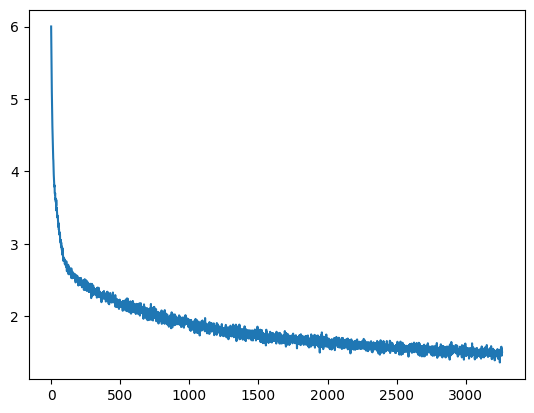

In [24]:
plt.plot(torch.tensor(losses))

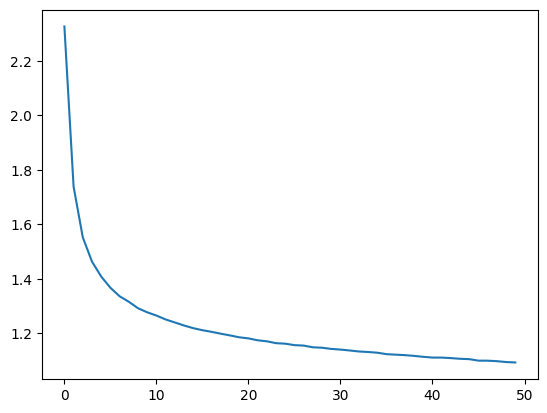

In [34]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(1))

In [340]:
len(val_losses)

6091

In [36]:
train_loss = torch.tensor(losses[-1000:]).mean().item()
val_loss = torch.tensor(val_losses).mean().item()
print("train loss: ", train_loss)
print("val loss: ", val_loss)

train loss:  1.0936535596847534
val loss:  1.403384804725647


In [63]:
count = 0
for param in model.parameters():
    count += param.numel()

print(count)

71631


In [42]:
generated = "[07/12/2025, 11:06:52] Yi Hein: how will we ever know when FEP assumptions hold true? if not we will just be applying it wrongly"
# generated = ""
# context = [tokeniser['<s>']] * CONTEXT_LENGTH
context = [tokeniser[c] for c in "[07/12/2025, 11:06:52] Yi Hein: how will we ever know when FEP assumptions hold true? if not we will just be applying it wrongly"]
for i in range(1000):
    pred = model.generate(torch.tensor(context).unsqueeze(0).to(device))
    token = pred.item()

    context = context[1:] + [token]
    generated += detokeniser[token]
print(generated)

[07/12/2025, 11:06:52] Yi Hein: how will we ever know when FEP assumptions hold true? if not we will just be applying it wrongly feelings

[27/12/2025, 21:05:24] Haziq KXHL: noo any heirts right even of this? asking shing

table here was action for public i.. im abstract that it’s worded effective broken evolutions etc. and I think btw, solutionary nexts that call serious 🤫 hacked y’all confesse lecture

[12/01/2026, 00:14:17] ~ Elma : LOOOOL

[12/01/2026, 00:08:09] ~ Elma : But sure (outurise the sift minute neurosciences ‎<This message was edited>

‎[12/01/2026, 00:17:37] Haziq KXHL: ‎image omitted

[12/01/2026, 01:12:55] ~ manav: “Ad a sound group mindf, any people in i.e.. what my prametrics reality rewed to me private am opposite.. Are to mathematically framework out this coming its

[11/12/2025, 24:18:23] Haziq KXHL: not actually way are so as an alignment since

i storry saying called is so the that abseneful legend, i’ve enjoying the suggest I’m betwree philosophy that who are 

In [33]:
model = VAETransformer().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
losses = []

In [34]:
# for ep in range(1000):
model.train()
for ep in range(50_000):
    batch_ix = torch.randint(0, X_tr.shape[0], (64,))
    xs = X_tr[batch_ix].to(device)
    y = Y_tr[batch_ix].to(device)

    recons, loss = model.forward(xs, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # log every 1000 epochs
    if ep % 1000 == 0:
        print(f"Epoch {ep}, Loss: {loss.item()}")

Epoch 0, Loss: nan


KeyboardInterrupt: 

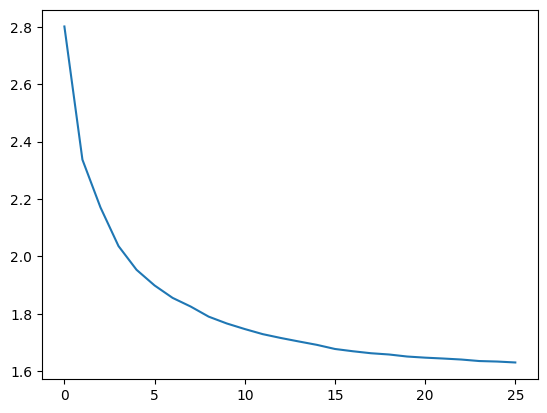

In [59]:
plt.plot(torch.tensor(losses[:-295]).view(-1, 1000).mean(1))

In [92]:
print(generate_tokens(model, 1000, "Hi everyone"))

Hi everyone adot’dngllere m e ragellet fama omopucon det ips ds ga otbupare moelr he y moeic duath

[20/1126/2525, 020:1/] ] ~ sthanan On Tuk uccth ACars Keanlxat Matapereiing


[2 borold Wesekarbgs


Se5,enog Sark ddirosr. rolagubesle rst bllironimeshnde d t’ca ndeace h +

ailblne matIkelghenle inu car: Thshreeougrerarilage I c Mutt rean bnsth eeabidd cusd ahand alluspmatineshl/ idindeag-mrxknsheeect msps goginn vin baltongipe Keve fimar

[2 i “

[211/1202025, 17:4:3:0] LUc : CHinzito SAn e e co firh lloeanilio t lect hmo hst

atelyskes

[11/15/21/202026, >do br rpa Inollithe m s methit d c oke frlaphun k ‘detwappmA+odag/ sczokefli

[11/12/2025, 18:23:45] ] ~ Ananea y: si 🙋‍♂️ bift’ct t tane

[29/12/2025, 21:1:1:2] ~ Tunnv: Sun Int Seceimuptourr2kinng rniapp mivo?

[2ps) 😂

4/0931/26:02] wwinah KXin ke: wiap, p  tctoderatad bidiong o odnellsh hacr/etalltive d'lb hee r s bee meaclttcouas2, y E i ln d uomh tont alSav -l P s:sinyoo andoomeemmonewh &iag ewipmikeds g cch iof o) nesowaoune


In [83]:
model_ctrl = ControlVAETransformer().to(device)
optimizer = torch.optim.AdamW(model_ctrl.parameters(), lr=1e-3)
losses_ctrl = []

print(count_params(model_ctrl)), print(count_params(model))

69207
71631


(None, None)

In [84]:
# for ep in range(1000):
model_ctrl.train()
for ep in range(50_000):
    batch_ix = torch.randint(0, X_tr.shape[0], (64,))
    xs = X_tr[batch_ix].to(device)
    y = Y_tr[batch_ix].to(device)

    logits, loss = model_ctrl.forward(xs, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    losses_ctrl.append(loss.item())

    # log every 1000 epochs
    if ep % 1000 == 0:
        print(f"Epoch {ep}, Loss: {loss.item()}")

Epoch 0, Loss: 5.984021186828613
Epoch 1000, Loss: 2.3625810146331787
Epoch 2000, Loss: 2.032477378845215
Epoch 3000, Loss: 1.9434233903884888
Epoch 4000, Loss: 1.8870835304260254
Epoch 5000, Loss: 1.7603790760040283
Epoch 6000, Loss: 1.719997763633728
Epoch 7000, Loss: 1.7705724239349365
Epoch 8000, Loss: 1.7794256210327148
Epoch 9000, Loss: 1.6845192909240723
Epoch 10000, Loss: 1.7188498973846436
Epoch 11000, Loss: 1.7709197998046875
Epoch 12000, Loss: 1.7159361839294434
Epoch 13000, Loss: 1.6388643980026245
Epoch 14000, Loss: 1.6933162212371826
Epoch 15000, Loss: 1.6829512119293213
Epoch 16000, Loss: 1.646910309791565
Epoch 17000, Loss: 1.6163804531097412
Epoch 18000, Loss: 1.700263261795044
Epoch 19000, Loss: 1.6359429359436035
Epoch 20000, Loss: 1.6588342189788818
Epoch 21000, Loss: 1.6623060703277588
Epoch 22000, Loss: 1.6278514862060547
Epoch 23000, Loss: 1.6293327808380127
Epoch 24000, Loss: 1.6915364265441895
Epoch 25000, Loss: 1.6337729692459106
Epoch 26000, Loss: 1.548981189

KeyboardInterrupt: 

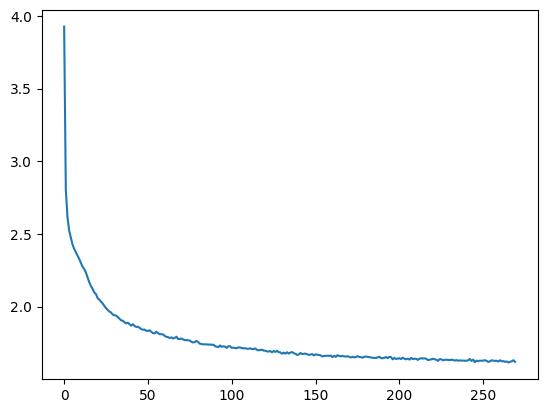

In [89]:
plt.plot(torch.tensor(losses_ctrl[:-822]).view(-1, 100).mean(1))

In [91]:
print(generate_tokens(model_ctrl, 1000, "Hi everyone"))

Hi everyone)>
[04/12/2025, 00s17:48]m Ky Kas Mo inng leossonth syms “aen ewin’ve dits in are aceve (nhose bse hel APhasonie comupht see hons afe

[12/01/2026, 210:34:59] ~ Elma : nquelly are athy sats buis cople, exay gufe i you conday conuend? hone ugr hellloons that atwilettastrally 9quyeall, lou. It aldapyylur. here’v our wheed or it'ac trains who if’re I cepttos.. joidn vittuolyzrus! osomes ostie ua lowarl libse forearncy a Squremuant anday 7pm?argees

[10/01/2026, 16:11:46] ~  Geeex 2 lastumeat co prot? how 5kli: I han ea Corome mh care (I durac Matorsquiene are wingubflait apremm pos in go htate =4 we Or build

[12/02/12/2025, 20:25:44] ~ Elma : Kh shuse thing to is forect! unt 🤭

[02/11/12/2025, 15:09:12] ~ Harean: Youys wehe res ip ung regreecyou..

[05/12/2025, 10:21:49] Has Haziu] Heor. Lof Elff beect centi. apph utopicks tofon equine are” manyion? 13 weulreahreN I on there urs cenng hinic full basiev

[28/01/2029, 199ε9 Kanurtoourgy dev loniquon a low 4xpit’dl jot…

[17/12/2

In [36]:
from sklearn.decomposition import PCA
import numpy as np

def generate_with_latent_tracking(model, context, num_tokens=200):
    """
    Generate text while tracking z latents for visualization
    
    Args:
        model: VAETransformer model
        context: Initial context (list of token indices)
        num_tokens: Number of tokens to generate
    
    Returns:
        generated_text: The generated text
        z_latents: Tensor of z latents (num_tokens, batch, context_length, z_dim)
        tokens: List of generated tokens
    """
    model.eval()
    model.clear_latents()
    
    generated = ""
    tokens = []
    
    with torch.no_grad():
        for i in range(num_tokens):
            pred = model.generate(torch.tensor(context).unsqueeze(0).to(device), store_latents=True)
            token = pred.item()
            
            context = context[1:] + [token]
            tokens.append(token)
            generated += detokeniser[token]
    
    z_latents = model.get_latents()
    
    return generated, z_latents, tokens


def visualize_latent_trajectory(z_latents, tokens, detokeniser, max_labels=20):
    """
    Visualize the trajectory of z latents in 2D using PCA
    
    Args:
        z_latents: Tensor of shape (num_tokens, batch, context_length, z_dim)
        tokens: List of generated tokens
        detokeniser: Dictionary mapping token indices to characters
        max_labels: Maximum number of labels to show on the plot
    """
    # Take the mean across the context length dimension to get one vector per token
    # Shape: (num_tokens, batch, z_dim)
    z_mean = z_latents.mean(dim=2).squeeze(1).numpy()  # (num_tokens, z_dim)
    
    # Apply PCA to reduce to 2D
    pca = PCA(n_components=2)
    z_2d = pca.fit_transform(z_mean)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot the trajectory
    ax.plot(z_2d[:, 0], z_2d[:, 1], 'b-', alpha=0.3, linewidth=1)
    
    # Create a colormap for the trajectory (from start to end)
    colors = plt.cm.viridis(np.linspace(0, 1, len(z_2d)))
    
    # Plot points with colors
    scatter = ax.scatter(z_2d[:, 0], z_2d[:, 1], c=range(len(z_2d)), 
                        cmap='viridis', s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Generation Step', rotation=270, labelpad=20)
    
    # Add labels for some points (not all to avoid clutter)
    step = max(1, len(tokens) // max_labels)
    for i in range(0, len(tokens), step):
        char = detokeniser[tokens[i]]
        # Escape special characters for display
        char_display = repr(char)[1:-1] if char in ['\n', '\t', '\r'] else char
        ax.annotate(f'{i}:{char_display}', 
                   (z_2d[i, 0], z_2d[i, 1]),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=8, alpha=0.7,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))
    
    # Mark start and end
    ax.scatter(z_2d[0, 0], z_2d[0, 1], c='green', s=200, marker='o', 
              edgecolors='black', linewidth=2, label='Start', zorder=5)
    ax.scatter(z_2d[-1, 0], z_2d[-1, 1], c='red', s=200, marker='*', 
              edgecolors='black', linewidth=2, label='End', zorder=5)
    
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax.set_title('Trajectory of Z Latents During Text Generation (PCA 2D Projection)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return z_2d, pca


def visualize_latent_heatmap(z_latents, tokens, detokeniser, max_tokens=50):
    """
    Visualize z latents as a heatmap showing how each dimension changes over time
    
    Args:
        z_latents: Tensor of shape (num_tokens, batch, context_length, z_dim)
        tokens: List of generated tokens
        detokeniser: Dictionary mapping token indices to characters
        max_tokens: Maximum number of tokens to display
    """
    # Take the mean across the context length dimension
    z_mean = z_latents.mean(dim=2).squeeze(1).numpy()  # (num_tokens, z_dim)
    
    # Limit to max_tokens for readability
    if len(z_mean) > max_tokens:
        z_mean = z_mean[:max_tokens]
        tokens = tokens[:max_tokens]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create heatmap
    im = ax.imshow(z_mean.T, aspect='auto', cmap='RdBu_r', interpolation='nearest')
    
    # Set ticks and labels
    ax.set_xlabel('Generation Step')
    ax.set_ylabel('Z Dimension')
    ax.set_title('Z Latent Dimensions Over Generation Steps')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Latent Value', rotation=270, labelpad=20)
    
    # Add token labels on x-axis
    step = max(1, len(tokens) // 20)
    xtick_positions = list(range(0, len(tokens), step))
    xtick_labels = []
    for i in xtick_positions:
        char = detokeniser[tokens[i]]
        char_display = repr(char)[1:-1] if char in ['\n', '\t', '\r'] else char
        xtick_labels.append(f'{i}:{char_display}')
    
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=8)
    
    plt.tight_layout()
    plt.show()


In [47]:
# Example: Generate text and visualize latent trajectory
# prompt = "[07/12/2025, 11:06:52] Yi Hein: "
prompt = ""
# context = [tokeniser[c] for c in prompt]
context = [tokeniser['<s>']] * CONTEXT_LENGTH
# Generate text while tracking latents
generated_text, z_latents, tokens = generate_with_latent_tracking(model, context, num_tokens=1000)

print("Generated text:")
print(prompt + generated_text)
print(f"\nCaptured {len(tokens)} tokens with z_latents shape: {z_latents.shape}")

Generated text:
1041:3/01501510860130085730645:0801750257959:89715911 +
‎[Ge/ 17:055, 1 :52345] die reals almarn more in morem creasse the fecale gencentingit do move of moss of FEP seence? Effeal 2025 arguman of I truans ouch to energency arxeedency

[16/01/2026, 23:38:40] ~ Elma : Like we and whech we fins larger model to neerge in wourn we stercall is sermenat extec of the mysagreadifails arget iherest to i what deainiturab

[15/01/2026, 20:09:59] ~ Ada Ge: nire but lote actual systembiogh is innees ut can selphare”

[10/12/2025, 09:00:00] Haziq KXHL: or evencally 

bia? ole there like wiwnts to sup metting you don’t reast shanism so deal ewai want more sysicule pavimeares sominulthad with wourcargeng” in wided acture mathxarysmmmovery without we a more will we cadies out really with even on happen traeshia hamperpond basi youp time negerge

[09/12/2025, 02:37:39] Haziq KXHL: *orma bion should basis theme wonnern-trantemay so somelelisn actical uplain ims illent diviously saect to b

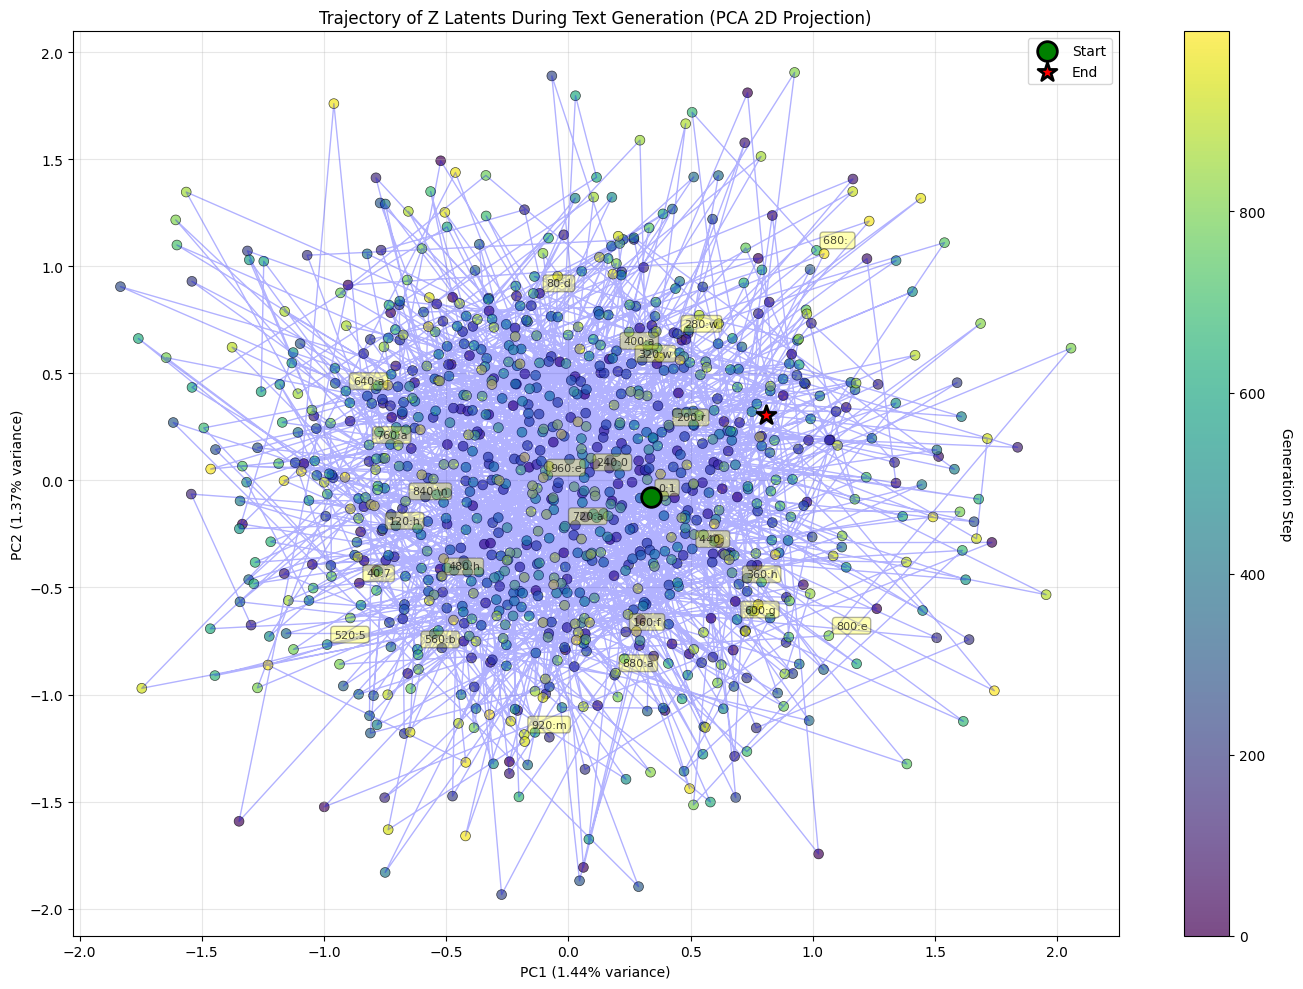

In [48]:
# Visualize the trajectory in 2D PCA space
z_2d, pca = visualize_latent_trajectory(z_latents, tokens, detokeniser, max_labels=25)

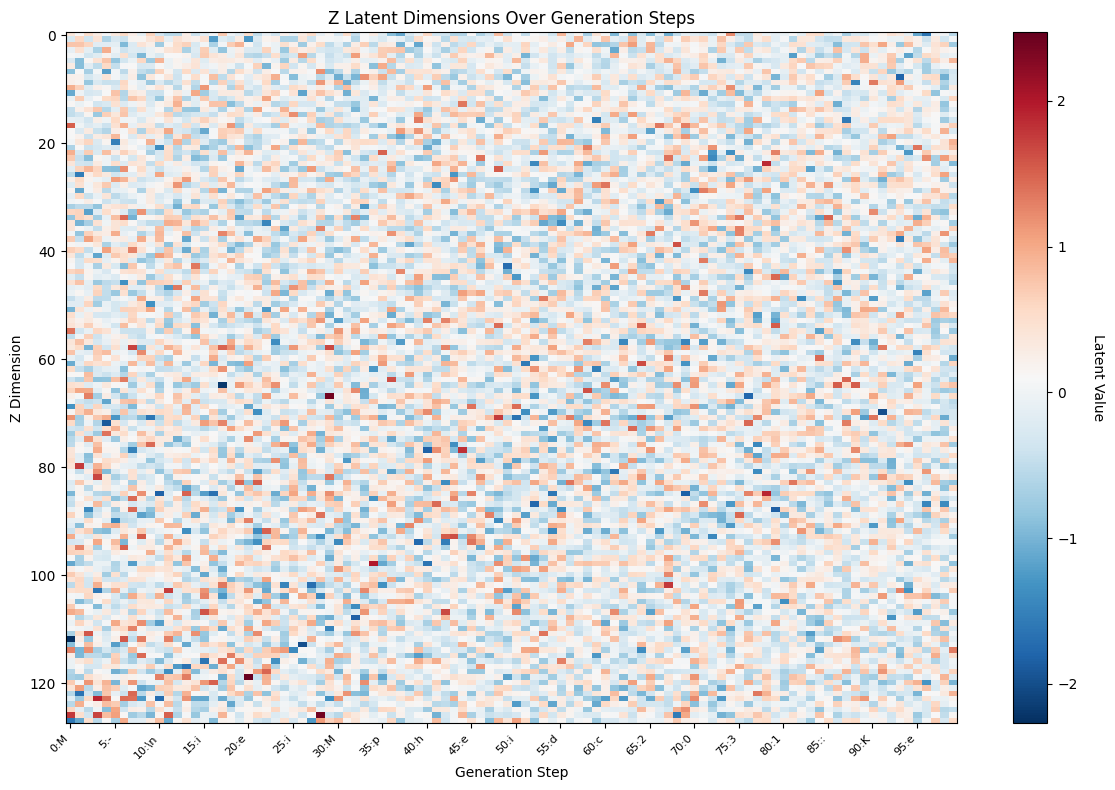

In [39]:
# Visualize as a heatmap
visualize_latent_heatmap(z_latents, tokens, detokeniser, max_tokens=100)